In [1]:
!pip install torchinfo

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import time
import warnings
from collections import defaultdict
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
import torchvision
from torchvision import transforms
from torchinfo import summary

import pandas as pd

from IPython.display import clear_output
sns.set(font_scale=1, style='darkgrid', palette='Set2')
warnings.simplefilter("ignore")

device = f"cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


---
### Классификация MNIST


In [4]:
# Данные для обучения
train_dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                           download=True,
                                           transform=transforms.ToTensor())
# Данные для тестирования
val_dataset = torchvision.datasets.MNIST(root='./data', train=False,
                                         download=True,
                                         transform=transforms.ToTensor())
# Классы объектов в датасете
classes = [str(i) for i in range(10)]

Размер картинки:torch.Size([1, 28, 28])


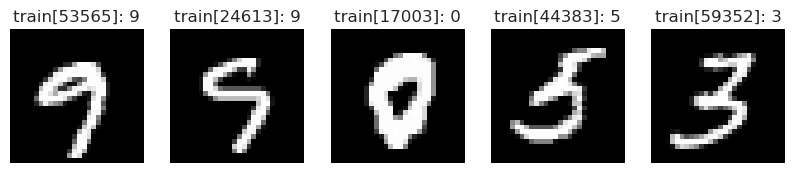

In [5]:
indices = np.random.randint(0, len(train_dataset), 5)
print(f"Размер картинки:{train_dataset[0][0].shape}")

plt.figure(figsize=(10, 7))
for i in range(len(indices)):
    plt.subplot(2, len(indices), i + 1)
    plt.imshow(train_dataset[indices[i]][0].permute(1, 2, 0), cmap='gray')
    plt.title(f"train[{indices[i]}]: {classes[train_dataset[indices[i]][1]]}")
    plt.axis("off")

In [ ]:
batch_size = 64

train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

In [ ]:
def print_epoch(epoch, num_epochs, history, t):
    """
    Функция для вывода информации про эпоху.
    :param epoch: номер эпохи
    :param num_epochs: общее количество эпох
    :param history: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    :param t: время эпохи в секундах
    """
    clear_output(wait=True)
    print("Epoch {} of {} took {:.3f} s".format(epoch + 1, num_epochs, t))
    print("  training loss: \t{:.6f}".format(history["loss"]["train"][-1]))
    print("  validation loss: \t{:.6f}".format(history["loss"]["val"][-1]))
    print(
        "  training accuracy: \t\t\t{:.2f} %".format(
            history["acc"]["train"][-1] * 100
        )
    )
    print(
        "  validation accuracy: \t\t\t{:.2f} %".format(
            history["acc"]["val"][-1] * 100
        )
    )


def update_history(history, loss, time, acc, num_batches, mode):
    """
    Функция для сохранения лосса и точности в историю.
    :param history: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    :param loss: сумма лосса за весь батч
    :param acc: сумма точности за весь батч
    :param num_batches: общее количество батчей
    :param mode: train или val
    """
    # Подсчитываем лоссы и сохраняем в "историю"
    loss /= num_batches
    acc /= num_batches
    history["loss"][mode].append(loss)
    history["acc"][mode].append(acc)
    history["time"][mode].append(time)


def get_batch_loss(
    X_batch, y_batch, model, criterion, current_loss, current_acc
):
    """
    Функция для подсчета лосса (без backward pass).
    :param X_batch: батч картиок X
    :param y_batch: батч меток y
    :param model: модель для получения логитов
    :param criterion: функция потерь
    :param current_loss: текущий суммарный лосс за батч
    :param current_acc: текущая суммарная точность за батч
    :return: лосс на данном батче; current_loss; current_acc
    """

    # Обучаемся на батче (одна "итерация" обучения нейросети)
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)

    # Логиты на выходе модели
    logits = model(X_batch)

    # Подсчитываем лосс
    loss = criterion(logits, y_batch.long().to(device))

    # Сохраняем лоссы и точность на трейне
    current_loss += loss.detach().cpu().numpy()
    y_pred = logits.max(1)[1].detach().cpu().numpy()
    current_acc += np.mean(y_batch.cpu().numpy() == y_pred)
    return loss, current_loss, current_acc, X_batch[y_pred != y_batch.cpu().numpy()], y_batch[y_pred != y_batch.cpu().numpy()], y_pred[y_pred != y_batch.cpu().numpy()]

def train(
    model, criterion, optimizer, train_batch_gen, val_batch_gen, num_epochs=40
):
    """
    Функция для обучения модели и вывода лосса и метрики во время обучения.

    :param model: обучаемая модель
    :param criterion: функция потерь
    :param optimizer: метод оптимизации
    :param train_batch_gen: генератор батчей для обучения
    :param val_batch_gen: генератор батчей для валидации
    :param num_epochs: количество эпох
    :return: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    """

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss, val_loss = 0, 0
        train_acc, val_acc = 0, 0
        start_time = time.time()

        # ----------------------   ОБУЧЕНИЕ   ----------------------#
        model.train(True)
        # На каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # Считаем лосс, обновляем train_loss, train_acc
            loss, train_loss, train_acc, _, _, _ = get_batch_loss(
                X_batch, y_batch, model, criterion, train_loss, train_acc
            )

            # Обратный проход
            loss.backward()
            # Шаг градиента
            optimizer.step()
            # Зануляем градиенты
            optimizer.zero_grad()

        # Подсчитываем лоссы и сохраняем в "историю"
        update_history(
            history, train_loss, time.time() - start_time, train_acc, len(train_batch_gen), "train"
        )

        # ----------------------   ВАЛИДАЦИЯ   ----------------------#
        model.train(False)
        # Контекстный менеджер, отключающий подсчет градиентов
        with torch.no_grad():
            # Полный проход по валидационному датасету
            for X_batch, y_batch in val_batch_gen:
                # Считаем лосс, обновляем val_loss, val_acc
                _, val_loss, val_acc, _, _, _ = get_batch_loss(
                    X_batch, y_batch, model, criterion, val_loss, val_acc
                )

        # Подсчитываем лоссы и сохраняем в "историю"
        update_history(history, val_loss, time.time() - start_time, val_acc, len(val_batch_gen), "val")

        # Печатаем результаты после каждой эпохи
        print_epoch(epoch, num_epochs, history, time.time() - start_time)

    return history

def predict(model, criterion, optimizer, val_batch_gen):

    val_loss = [0] * 10
    val_acc = [0] * 10
    incorrect_pred_x = []
    incorrect_pred_y = []
    incorrect_pred = []

    model.train(False)

    with torch.no_grad():

        for X_batch, y_batch in val_batch_gen:

            for i in range(10):
                if len(y_batch[y_batch == i]) != 0:
                    _, val_loss[i], val_acc[i], incorr_X, incorr_y, incorr_pred = get_batch_loss(
                      X_batch[y_batch == i], y_batch[y_batch == i], model, criterion, val_loss[i], val_acc[i]
                    )
                    for j in range(len(incorr_y)):
                        incorrect_pred_x.append(incorr_X[j])
                        incorrect_pred_y.append(incorr_y[j])
                        incorrect_pred.append(incorr_pred[j])

    num_batches = len(val_batch_gen)
    for i in range(10):
        val_loss[i] /= num_batches
        val_acc[i] /= num_batches
    return val_loss, val_acc, incorrect_pred_x, incorrect_pred_y, incorrect_pred

In [ ]:
def plot_histories(histories, names):
    """
    Функция для визуализации лосса и метрики по нескольким историям.
    :param history: (list) список историй моделей
    :param names: (list) список названий моделей
    """
    sns.set_style("darkgrid")
    colors = ["darkblue", "limegreen", "sandybrown", "lightcoral", "purple"]
    fig, axs = plt.subplots(3, 1, figsize=(14, 24))

    epochs = np.min([len(h["loss"]["train"]) for h in histories])
    for i, (history, name) in enumerate(zip(histories, names)):
        axs[0].set_title("Лосс")
        axs[0].plot(
            history["loss"]["train"][:epochs],
            label=f"{name}",
            lw=2,
            c=colors[i],
            alpha = 0.3,
            ls="--"
        )
        axs[0].plot(
            history["loss"]["val"][:epochs], lw=1.5, c=colors[i]
        )
        axs[0].set_xlabel("Эпохи")

        axs[1].set_title("Точность")
        axs[1].plot(
            history["acc"]["train"][:epochs], label=f"{name}", lw=2, c=colors[i], alpha = 0.3, ls="--"
        )
        axs[1].plot(
            history["acc"]["val"][:epochs], lw=1.5, c=colors[i]
        )
        axs[1].set_xlabel("Эпохи")
        axs[1].legend()

        axs[2].set_title("Время")
        axs[2].plot(
            history["time"]["train"][:epochs], label=f"{name}", lw=2, c=colors[i], alpha = 0.3, ls="--"
        )
        axs[2].plot(
            history["time"]["val"][:epochs], lw=1.5, c=colors[i]
        )
        axs[2].set_xlabel("Эпохи")
        axs[2].legend()

    dummy_lines = [
        axs[0].plot([], [], c="black", lw=2, ls="--")[0],
        axs[0].plot([], [], c="black", lw=1.5)[0],
    ]
    legend = axs[0].legend(loc='upper right')
    axs[0].legend(dummy_lines, ["train", "val"], loc='lower left')
    axs[0].add_artist(legend)
    for i in range(1, 3):
        legend = axs[i].legend(loc='lower right')
        axs[i].legend(dummy_lines, ["train", "val"], loc='upper left')
        axs[i].add_artist(legend)

    plt.show()

In [ ]:
models = []

models.append(nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=676, out_features=10),
).to(device))

models.append(nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(in_features=676, out_features=10),
).to(device))

models.append(nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(in_features=676, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device))

models.append(nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=20, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(in_features=3380, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device))

models.append(nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=20, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(in_channels=20, out_channels=40, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(in_features=1000, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device))

In [ ]:
for i, i_model in enumerate(models):
    print("########## model ", i, "##########\n", summary(i_model, input_size=(1, 1, 28, 28)))

########## model  0 ##########
Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 1, 26, 26]            10
├─ReLU: 1-2                              [1, 1, 26, 26]            --
├─Flatten: 1-3                           [1, 676]                  --
├─Linear: 1-4                            [1, 10]                   6,770
Total params: 6,780
Trainable params: 6,780
Non-trainable params: 0
Total mult-adds (M): 0.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.03
Estimated Total Size (MB): 0.04
########## model  1 ##########
Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 4, 26, 26]            40
├─ReLU: 1-2                              [1, 4, 26, 26]            --
├─MaxPool2d: 1-3

Обучим сети, используя функцию потерь `nn.CrossEntropyLoss` и оптимизатор `torch.optim.Adam` с дефолтными параметрами.

In [ ]:
histories = []

for cur_model in models:
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(cur_model.parameters())

    histories.append(train(
        cur_model,
        criterion,
        optimizer,
        train_batch_gen,
        val_batch_gen,
        num_epochs=20,
    ))

Epoch 20 of 20 took 10.403 s
  training loss: 	0.002169
  validation loss: 	0.052373
  training accuracy: 			99.93 %
  validation accuracy: 			99.12 %


Построим график лосса и график accuracy, где сравниваются все модели (на train и на val)

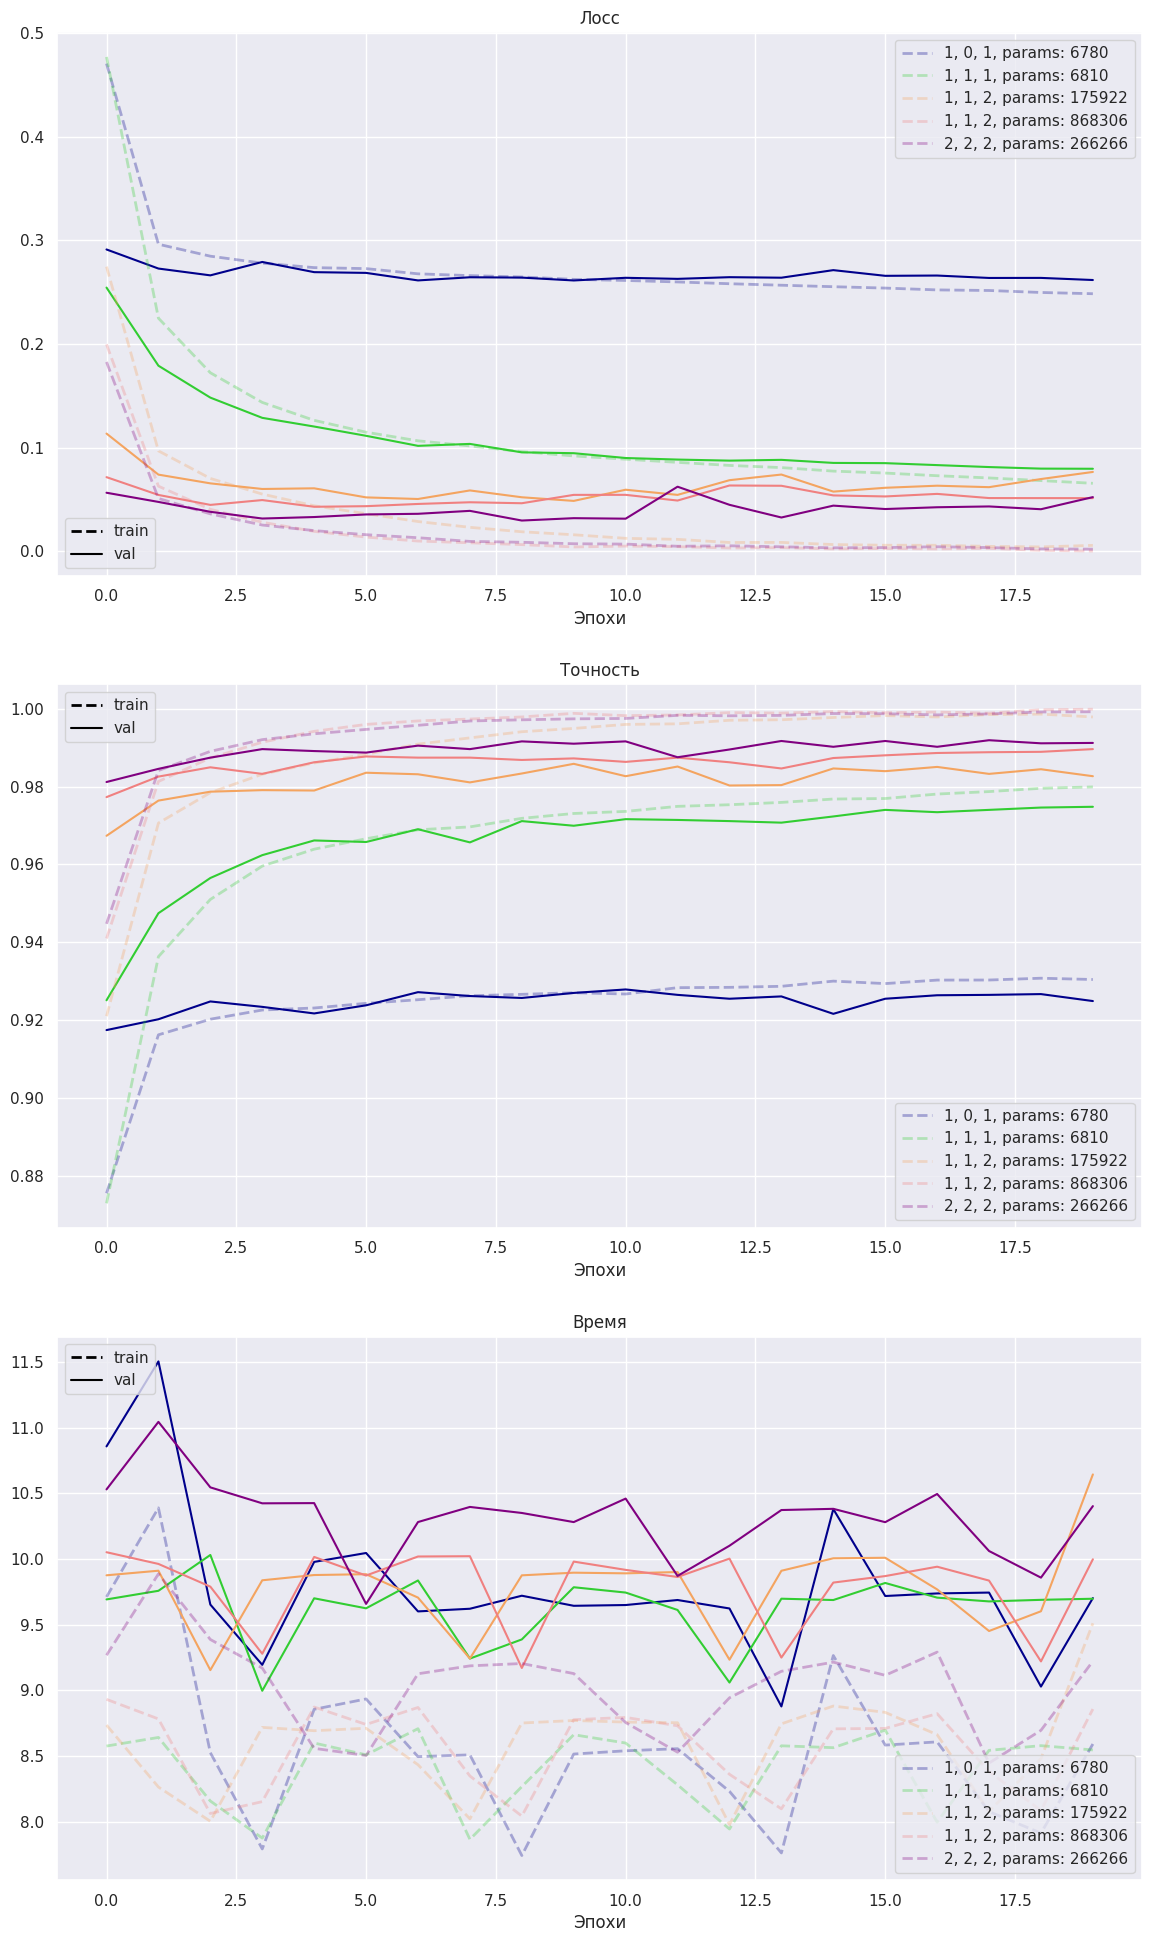

In [ ]:
plot_histories(histories, ["1, 0, 1, params: 6780", "1, 1, 1, params: 6810", "1, 1, 2, params: 175922", "1, 1, 2, params: 868306", "2, 2, 2, params: 266266"])

Цифры в легенде значат: кол-во свёрток, кол-во пулингов, кол-во линейных слоёв

**Вывод по эксперименту 1:**
1. Из результатов нашего эксперимента видно, что при увеличении количества слоев и их усложнении качество обучения увеличивается. Первая и вторая нейросеть несильно отличаются количеством обучаемых параметров, но имеют разную архитектуру (во второй добавляется слой пулинга). Вторая нейросеть значительно обыгрывает в точности первую.
2. Значительное увеличение обучаемых параметров, например благодаря усложнению линейных слоёв, дает очень небольшое улучшение точности (третья модель имеет на 1 линейный слой больше и намного больше параметров, чем вторая, но её точность превышает вторую несильно)
3. 4-я нейросеть имеет в 4 раза больше параметров, но менее сложную архитектуру, чем у 5-й, поэтому качество 5-й модели лучше
4. Лучше всего показала себя 5-я модель, имеющая 2 свёрточных слоя, 2 слоя пулинга, 2 линейных слоя и функции активации ReLu
5. Точность всех моделей на train лучше, чем на validate, потому что градиенты считались по выходам на train-е
6. Последние несколько эпох loss на val практически не меняется, но на train продолжает снижаться, из чего можно сделать вывод о полном обучении моделей и небольшом переобучении
7. Время прохождения одной эпохи практически не зависит от её номера, слегка колеблется. Время обучения более сложных моделей больше, чем у менее сложных

Лучший вариант из прошлого эксперимента - последняя модель с 2-мя свёрточными слоями, 2-мя слоями пулинга и 2 линейными слоями

In [ ]:
models = []

models.append(nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=20, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(in_channels=20, out_channels=40, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(in_features=1000, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device))

models.append(nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=20, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(in_channels=20, out_channels=40, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(in_features=640, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device))

models.append(nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(in_channels=20, out_channels=40, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(in_features=1000, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device))

models.append(nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(in_channels=20, out_channels=40, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(in_features=640, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device))

In [ ]:
histories2 = []

for cur_model in models:
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(cur_model.parameters())

    histories2.append(train(
        cur_model,
        criterion,
        optimizer,
        train_batch_gen,
        val_batch_gen,
        num_epochs=10,
    ))

Epoch 10 of 10 took 10.444 s
  training loss: 	0.007352
  validation loss: 	0.043180
  training accuracy: 			99.76 %
  validation accuracy: 			98.95 %


Построим график лосса и график accuracy, где сравниваются все модели этого эксперимента (на train и на val).

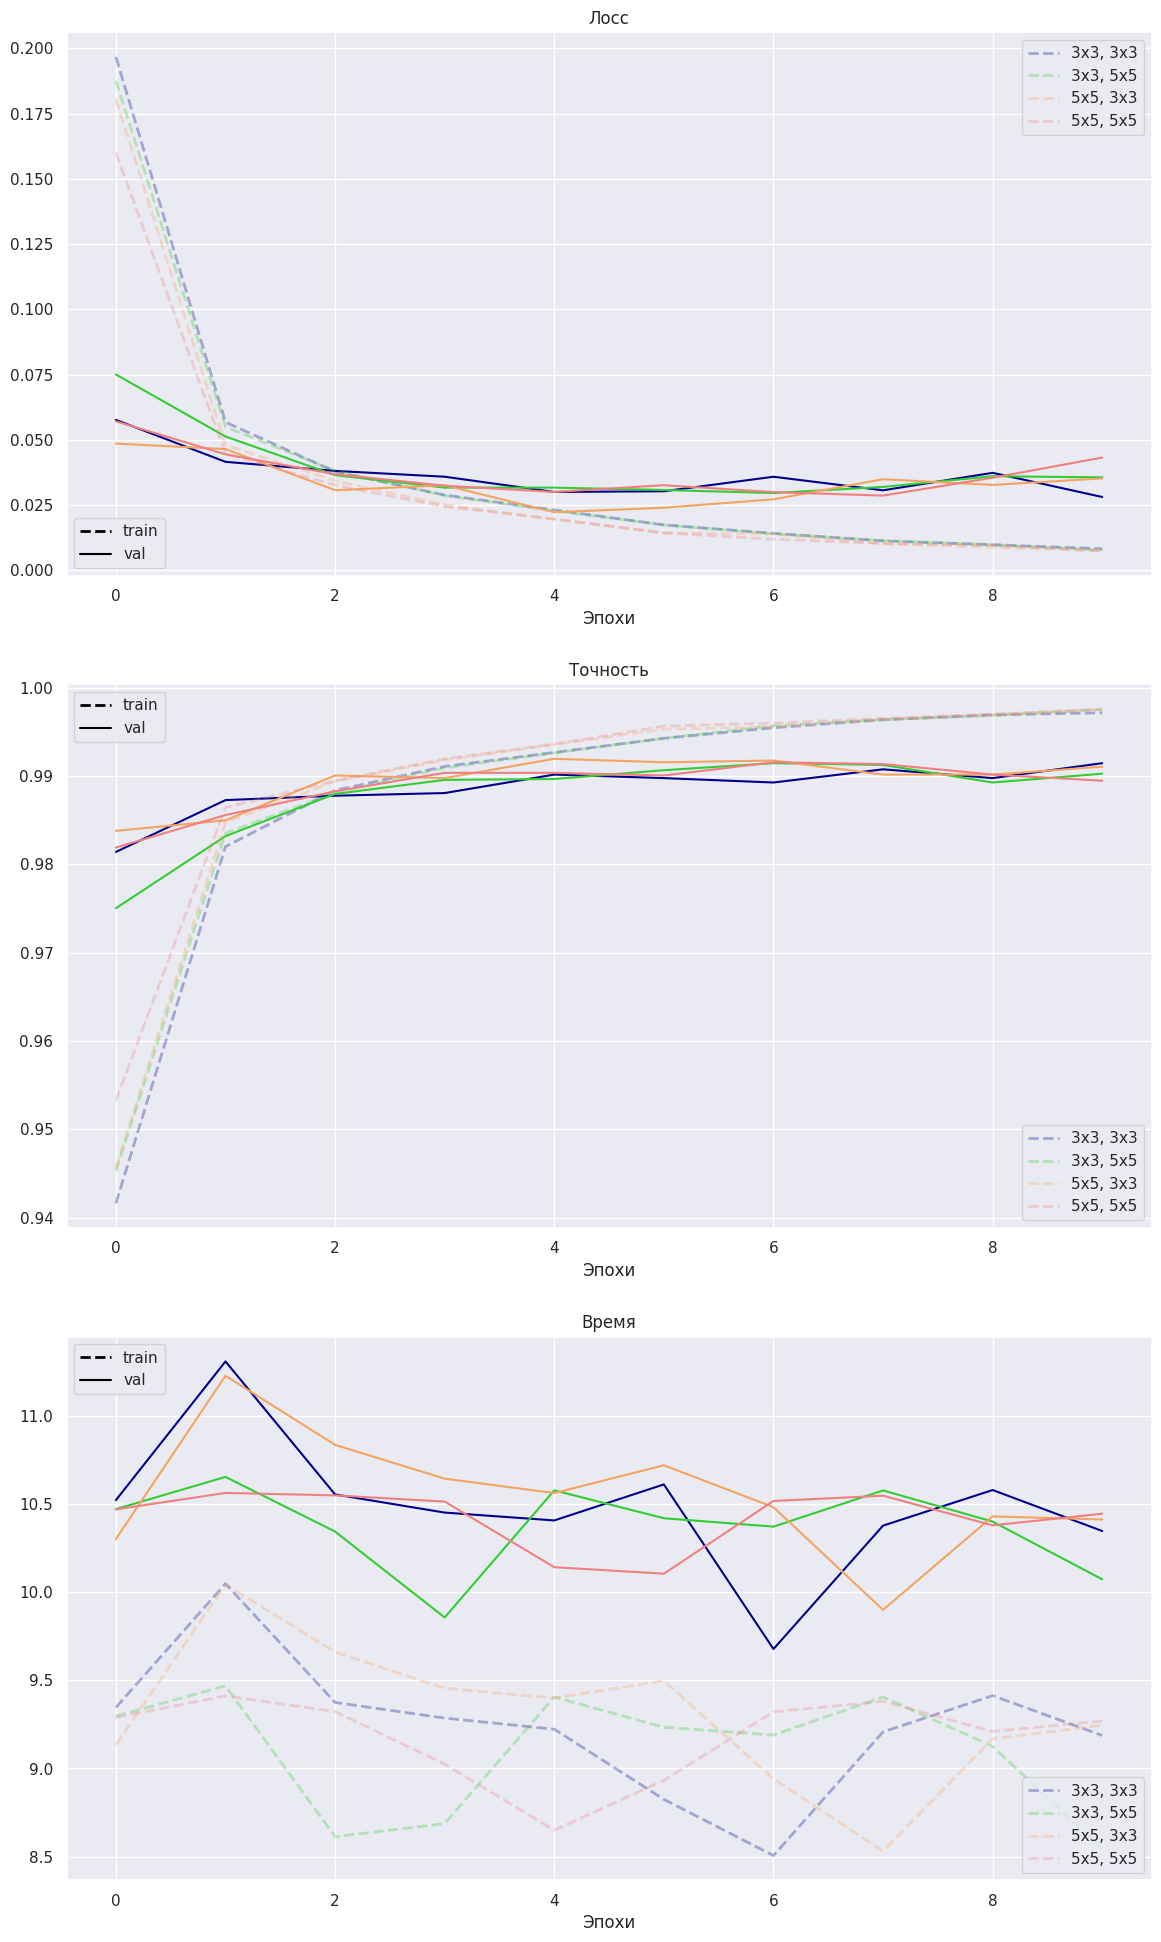

In [ ]:
plot_histories(histories2, ["3x3, 3x3", "3x3, 5x5", "5x5, 3x3", "5x5, 5x5"], )

**Вывод по эксперименту 2:**
1. Как и в первом эксперименте модели слегка переобучились, так как точность на train продолжала расти, а на val - нет, у некоторых моделей последние несколько эпох она стабильно снижалась
2. У моделей с большими ядрами сверток обучение прошло за меньшее количество эпох, последние несколько были лишними, началось переобучение
3. Разница между результатами моделей не такая сильная, как в прошлом эксперименте, однако можно выделить лучшую модель - с ядрами 5х5 и 5х5

лучшая модель - с ядрами 5х5 и 5х5

In [ ]:
val_loss, val_acc, incor_x, incor_y, incor_pred = predict(models[-1], criterion, optimizer, val_batch_gen)

In [ ]:
val_loss

[0.004577698499397265,
 0.0014906938342548427,
 0.03607548302719428,
 0.047467923222324925,
 0.005485059972361104,
 0.058621377717791655,
 0.049803338529637475,
 0.09062833709701001,
 0.028374157165081255,
 0.08829224823833251]

In [ ]:
val_acc

[0.9978768577494693,
 1.0,
 0.9879814983318168,
 0.9857698918208472,
 0.992012941057527,
 0.9870210292184814,
 0.9901981599433829,
 0.9679908732456504,
 0.9925993327267213,
 0.9788629754159915]

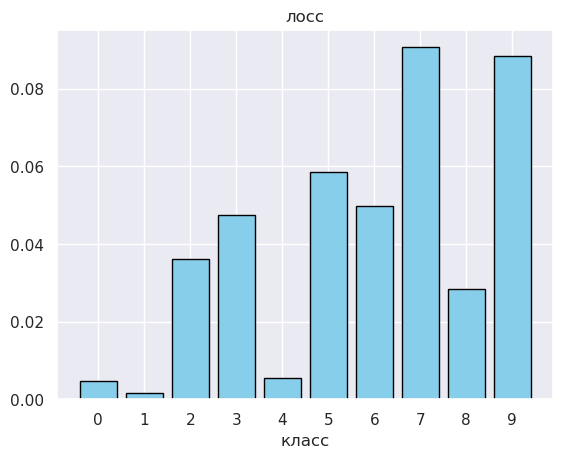

In [ ]:
plt.bar(range(10), height=val_loss, color='skyblue', edgecolor='black')
plt.title('лосс')
plt.xlabel('класс')
plt.xticks(range(10))
plt.show()

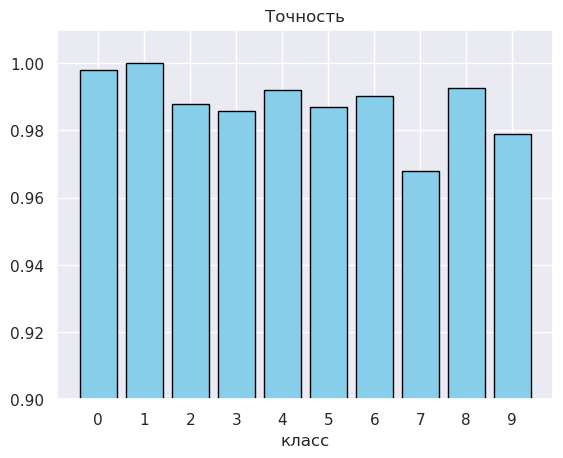

In [ ]:
plt.bar(range(10), height=val_acc, color='skyblue', edgecolor='black')
plt.title('Точность')
plt.xlabel('класс')
plt.xticks(range(10))
plt.ylim(0.9, 1.01)
plt.show()

У всех классов неплохая точность - больше 96%. Однако некоторые классы всё же распознаются моделью хуже других. Например, на единицах модель имеет точность 1, а на семёрках 0.967. Возможно, это сложнораспознаваемые классы, а возможно не хватило данных этих классов. Проверим это

In [ ]:
batch_size = len(train_dataset)

train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=False
)
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

for _, y_1 in train_batch_gen:
    y_train = y_1

for _, y_2 in val_batch_gen:
    y_val = y_2

y_train = pd.DataFrame(y_train.numpy())
y_val = pd.DataFrame(y_val.numpy())

y_val.columns = ['val']
y_train.columns = ['val']

In [ ]:
distrib = y_val.groupby('val')['val'].count()

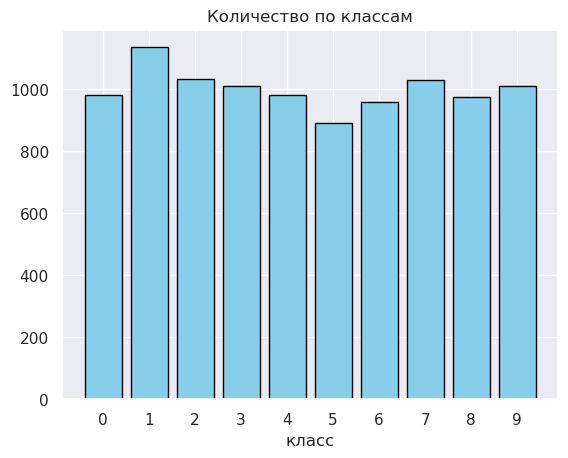

In [ ]:
plt.bar(range(10), height=distrib, color='skyblue', edgecolor='black')
plt.title('Количество по классам')
plt.xlabel('класс')
plt.xticks(range(10))
plt.show()

Как видно, изначальные данные достаточно равномерно распределены по искомым классам, цифр 5 меньше всего, однако точность распознавания пятёрок не самая худшая. Поэтому можно сделать вывод, что ключевой причиной плохого качества распознавания некоторых классов является сложность их распознавания или схожесть с другими

Я изначально сохранил все неправильные предсказания модели, выберем из них 5 случайных и посмотрим на них

In [ ]:
for i in range(len(incor_y)):
    incor_y[i] = incor_y[i].item()

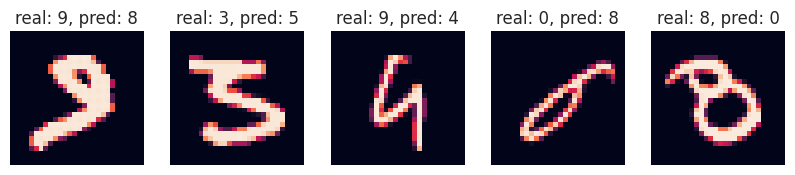

In [ ]:
plt.figure(figsize=(10, 7))

indices = np.random.randint(0, len(incor_y), 5)

for i in range(len(indices)):
    plt.subplot(2, len(indices), i + 1)
    plt.imshow(incor_x[indices[i]].permute(1, 2, 0).cpu())
    plt.title([incor_y[indices[i]], incor_pred[indices[i]]])
    plt.title(f"real: {incor_y[indices[i]]}, pred: {incor_pred[indices[i]]}")
    plt.axis("off")

**Ответ:** Видно, что это достаточно кривые цифры, некоторые из которых не сможет распознает человек, поэтому можно сделать вывод, что модель ошибается только на совсем плохо написанных цифрах. Всё же такие ошибки необходимо исключать или сводить к минимуму, нет предела совершенству, поэтому нужно улучшать методы решения таких задач

**Вывод по всей задаче:**
1. С усложнением архитектуры нейросети её качество растет (возможно, мы просто не достигли какой-то черты, дальше оно могло начать падать)
2. Свёрточная нейросеть с 2 слоями свёртки с ядрами 5x5, двумя max-пулингами 2x2 и двумя полносвязными линейными слоями дает очень неплохую точность на данном датасете (больше 99%). Ошибается она на кривых, неоднозначных цифрах. Некоторые классы распознаются хуже других из-за их схожестти с другими или других специфических параметров
3. Время обучения таких моделей достаточно большое, поэтому приходится обучать их на GPU, чтобы его уменьшить

### Работа с готовыми сетями

In [2]:
import os
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt

sns.set(palette="Set2")

In [3]:
!git clone https://github.com/nazianafis/Neural-Style-Transfer
# Перейдем в директорию скачанного репозитория
%cd /content/Neural-Style-Transfer/

# Небольшая обработка скрипта, не менять!
file_path = "NST.py"
with open(file_path, "r") as file:
    # Убираем автоматический запуск
    lines = file.readlines()[:183]
# Вывод логов только каждые 100 эпох
lines = lines[:175] + ["            if cnt % 100 == 0:\n"] + lines[175:]
lines[176] = "    " + lines[176]
with open(file_path, "w") as file:
    file.writelines(lines)

from NST import *

Cloning into 'Neural-Style-Transfer'...
remote: Enumerating objects: 379, done.
remote: Counting objects: 100% (154/154), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 379 (delta 72), reused 105 (delta 34), pack-reused 225
Receiving objects: 100% (379/379), 92.21 MiB | 30.73 MiB/s, done.
Resolving deltas: 100% (143/143), done.
/content/Neural-Style-Transfer


In [4]:
def run_neural_style_transfer(content_image="c1.jpg", style_image="s1.jpg"):
    """
    Функция для запуска метода Neural Style Transfer.

    :param content_image: имя файла картинки контента
    :param style_image: имя файла картинки стиля
    :return: results_path -- путь к папке, в которую сохранился результат
    """
    PATH = ""
    default_resource_dir = os.path.join(PATH, "data")
    content_images_dir = os.path.join(default_resource_dir, "content-images")
    style_images_dir = os.path.join(default_resource_dir, "style-images")
    output_img_dir = os.path.join(default_resource_dir, "output-images")
    img_format = (4, ".jpg")

    # Задаем конфиги, включая вес компонент лосса
    optimization_config = {
        "content_img_name": content_image,
        "style_img_name": style_image,
        "height": 400,
        "content_weight": 100000.0,
        "style_weight": 30000.0,
        "tv_weight": 1.0,
    }
    optimization_config["content_images_dir"] = content_images_dir
    optimization_config["style_images_dir"] = style_images_dir
    optimization_config["output_img_dir"] = output_img_dir
    optimization_config["img_format"] = img_format

    results_path = neural_style_transfer(optimization_config)
    return results_path

In [5]:
def visualize_style_transfer(content_image, style_image, results_path):
    """
    Визуализация результатов.

    :param content_image: имя файла картинки контента
    :param style_image: имя файла картинки стиля
    :param results_path: путь к папке, в которую сохранился результат
    """
    if len(os.listdir(results_path)) == 0:
        return
    plt.figure(figsize=(13, 3))
    folders = [
        "content-images/",
        "output-images/" + Path(results_path).name + "/",
        "style-images/",
    ]
    combined_image = (
        Path(content_image).stem + "_" + Path(style_image).stem + ".jpg"
    )
    files = [content_image, combined_image, style_image]
    titles = ["Контент", "Результат", "Стиль"]
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.imshow(plt.imread("data/" + folders[i] + files[i]))
        plt.title(titles[i])
        plt.xticks([])
        plt.yticks([])

In [6]:
content_images = sorted(os.listdir("data/content-images"))[1:]
style_images = sorted(os.listdir("data/style-images"))[1:]
result_paths = []
for content_image, style_image in zip(content_images, style_images):
    results_path = run_neural_style_transfer(content_image, style_image)
    result_paths.append(results_path)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:05<00:00, 113MB/s]


Using VGG19 in the optimization procedure.
L-BFGS | iteration: 000, total loss=363860656128.0000, content_loss=      0.0000, style loss=363847470000.0000, tv loss=13171997.0000
L-BFGS | iteration: 100, total loss=8657128448.0000, content_loss=1213060937.5000, style loss=7428802500.0000, tv loss=15264649.0000
L-BFGS | iteration: 200, total loss=3825886208.0000, content_loss=1162998535.1562, style loss=2646264375.0000, tv loss=16623362.0000
L-BFGS | iteration: 300, total loss=2408033024.0000, content_loss=1105072265.6250, style loss=1286182148.4375, tv loss=16778388.0000
L-BFGS | iteration: 400, total loss=1957929728.0000, content_loss=1062972656.2500, style loss=878265761.7188, tv loss=16691257.0000
L-BFGS | iteration: 500, total loss=1747627648.0000, content_loss=1030995214.8438, style loss=700020585.9375, tv loss=16611818.0000
L-BFGS | iteration: 600, total loss=1621117056.0000, content_loss=1006274414.0625, style loss=598282617.1875, tv loss=16560063.0000
L-BFGS | iteration: 700, tot

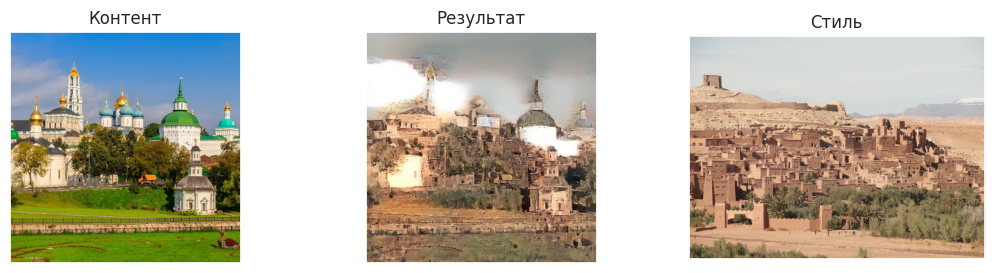

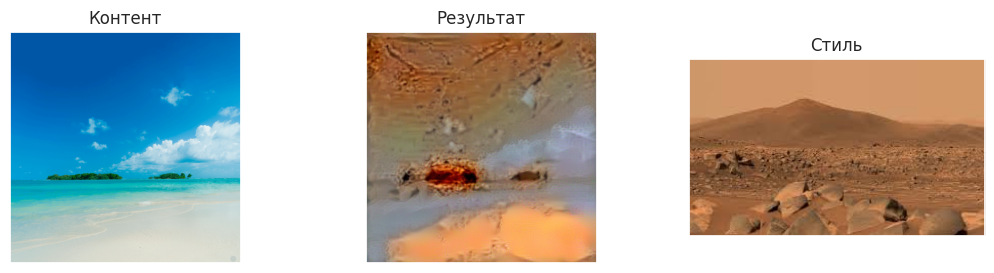

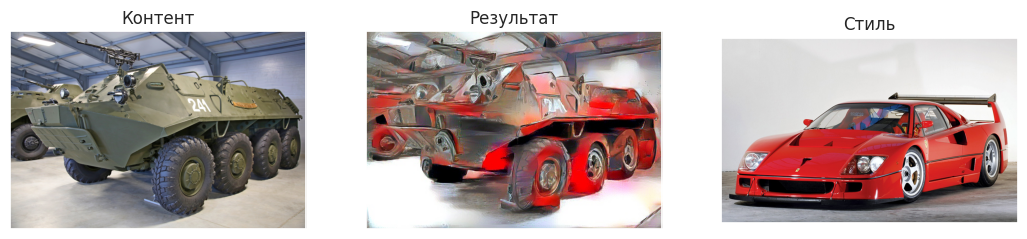

In [8]:
for content_image, style_image, results_path in zip(
    content_images, style_images, result_paths
):
    visualize_style_transfer(content_image, style_image, results_path)

Теперь для каждой пары контекст-стиль попытайтесь сгенерировать картинку с таким контекстом и стилем с помощью диффузионной модели, рассмотренной на семинаре, задав нужный промпт.

In [3]:
!pip install -q diffusers

In [4]:
from diffusers import AutoPipelineForText2Image
import torch

pipe = AutoPipelineForText2Image.from_pretrained(
    "stabilityai/sdxl-turbo", torch_dtype=torch.float16, variant="fp16"
).to("cuda")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

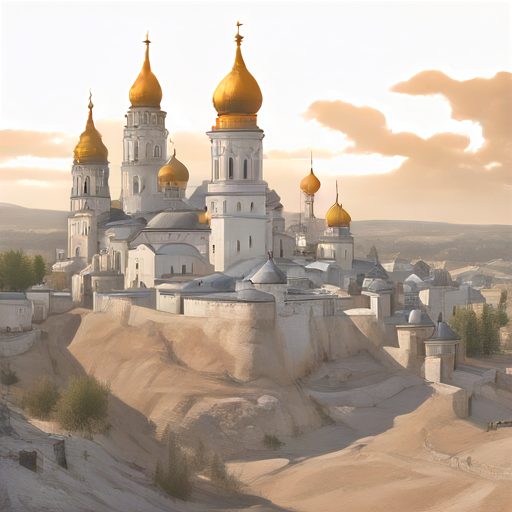

In [11]:
prompt = "sergiev posad many churches, desert sand architecture, white fortress wall, bell tower, from afar, artstation"

# Передаем prompt в pipe, указываем параметры
# Модель проводит генерацию картинки, соответствующей запросу
image = pipe(prompt=prompt, num_inference_steps=1, guidance_scale=0.0).images[0]
image

  0%|          | 0/1 [00:00<?, ?it/s]

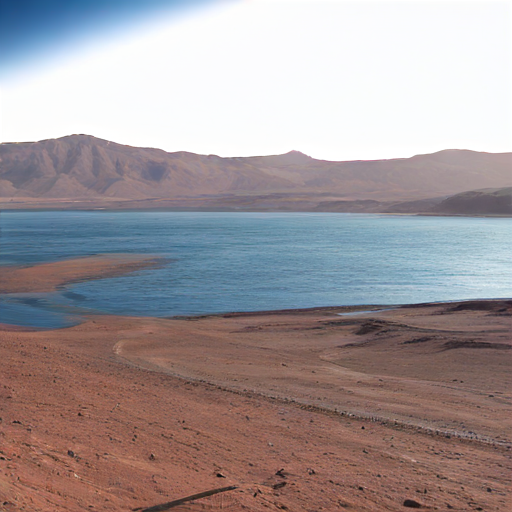

In [50]:
prompt = "beach, blue sea, little bit sky, Mars, mountains far away"

# Передаем prompt в pipe, указываем параметры
# Модель проводит генерацию картинки, соответствующей запросу
image = pipe(prompt=prompt, num_inference_steps=1, guidance_scale=0.0).images[0]
image

  0%|          | 0/1 [00:00<?, ?it/s]

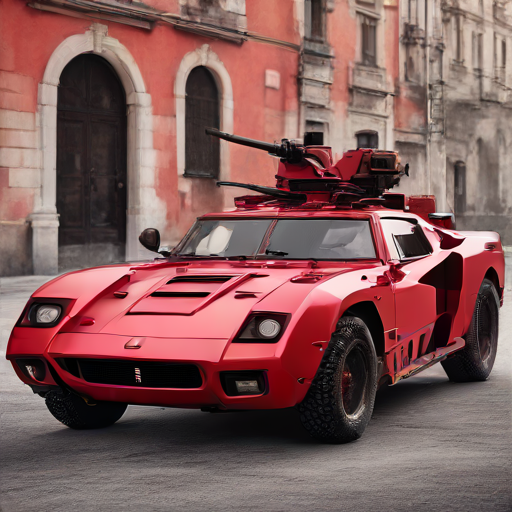

In [92]:
prompt = "military armored car with guns red ferrari"

# Передаем prompt в pipe, указываем параметры
# Модель проводит генерацию картинки, соответствующей запросу
image = pipe(prompt=prompt, num_inference_steps=1, guidance_scale=0.0).images[0]
image

**Вывод:**
Я применил Neural Style Transfer на собственных картинках, перенося стиль с картинки стиля на картинку контента. Когда стиль имеет равномерный характер, четко прослеживается настоящий "стиль", то результат получается неплохой, ожидаемый. Если же на картинке стиля много резких неоднородных деталей, то этот стиль плохо ложится на картинку с контентом (как в примере с бронемашиной и Ferrari).

Также Я запускал диффузионных моделей, пытаясь сгенерировать то, чего хотел добиться переносом стиля, получились интересные результаты. Для генерации необычных картинок по промту данная нейросеть справляется неплохо, получаются довольно точные, реалистичные и детализированные картинки